# Note-3: Benchmark ReDeeM using Crispr-based lineage tracing.
---

**Author:** Chen Weng

**Date:** October 27, 2023

## Description

This Jupyter Notebook aims reproduce the major analysis in Extended Data Fig. 5, 6

## Related Figures
- Extended Data Fig. 5 
- Extended Data Fig. 6 



---

# Install redeemR

In [1]:
#devtools::install_github("chenweng1991/redeemR")

# Import libraries

In [64]:
library(redeemR)
library(ggpubr)
library(igraph)
library(Matrix)
library(dplyr)
library(treeio)
library(ggtree)
library(gridExtra)

# Set path

In [3]:
## set main directory to the reproducibility_pub
Dir="/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/reproducibility_pub" # Change this to your actual path **/reproducibility_pub

In [4]:
source(paste(Dir,"/API/Revision.api",sep=""))

# Preprocess Crispr-based weighted hamming distance

## Batch1

In [11]:
Samples.batch1<-c("CD24_1","CD47_1","CD47_2","Ctrl_1","Ctrl_2","DKO_1")

In [12]:
## Read in a list of weighted hamming distance for each sample
whm.list<-list()
for(name in Samples.batch1){
filename=paste(Dir,"/data/CRISPR/batch1/weighted_hm_distance.",name,sep="")
    whm<-read.csv(filename,row.names = 1)
    whm.list<-c(whm.list,list(whm))
}
names(whm.list)<-Samples.batch1

In [13]:
## Preprocessing whm.list
whm.list<-lapply(whm.list,function(x){
    x[is.na(x)]<-1
    return(x)
})

#### CellNames are ATAC version names
CellNames<-lapply(whm.list,function(x){gsub("_","",Translate_simple_RNA2ATAC(row.names(x)))})
for(i in 1:6){
    row.names(whm.list[[i]])<-colnames(whm.list[[i]])<-paste(CellNames[[i]],"_1",sep="")
}

The following `from` values were not present in `x`: 1, 2, 3

The following `from` values were not present in `x`: 1, 2, 3

The following `from` values were not present in `x`: 1, 2, 3

The following `from` values were not present in `x`: 1, 2, 3

The following `from` values were not present in `x`: 1, 2, 3

The following `from` values were not present in `x`: 1, 2, 3



## Batch2

In [14]:
Samples.batch2<-c("NT1","NT2","T24_1","T24_2","T24_3","T47_1")

In [15]:
## Read in a list of weighted hamming distance for each sample
whm.list.batch2<-list()
for(name in Samples.batch2){
filename=paste(Dir,"/data/CRISPR/batch2/weighted_hm_distance.",name,sep="")
    whm<-read.csv(filename,row.names = 1)
    whm.list.batch2<-c(whm.list.batch2,list(whm))
}
names(whm.list.batch2)<-Samples.batch2

In [16]:
whm.list.batch2<-lapply(whm.list.batch2,function(x){
    x[is.na(x)]<-1
    return(x)
})
#### CellNames are ATAC version names
CellNames.batch2<-lapply(whm.list.batch2,function(x){gsub("_","",Translate_simple_RNA2ATAC(row.names(x)))})
for(i in 1:6){
    row.names(whm.list.batch2[[i]])<-colnames(whm.list.batch2[[i]])<-paste(CellNames.batch2[[i]],"_1",sep="")
}

The following `from` values were not present in `x`: 1, 2, 3

The following `from` values were not present in `x`: 1, 2, 3

The following `from` values were not present in `x`: 1, 2, 3

The following `from` values were not present in `x`: 1, 2, 3

The following `from` values were not present in `x`: 1, 2, 3

The following `from` values were not present in `x`: 1, 2, 3



In [18]:
## Combine batch1 and batch2
whm.list<-c(whm.list,whm.list.batch2)
CellNames<-c(CellNames,CellNames.batch2)

## Multidimensional scaling for CRISPR

In [19]:
## Make a wrapped function for dimension reduction for CRISPR hamming distances
Run_Crispr<-function(whm,N=7){
    cmd.fit <- cmdscale(whm,eig=TRUE, k=2)
    cmd.hc<-hclust(as.dist(whm))
    cmd.hc.clusters<-cutree(cmd.hc,k = N) %>% data.frame(cluster=.) %>% mutate(cluster=as.character(cluster))
    cmd.fit.result<-cmd.fit$point %>% as.data.frame() %>% Tomerge_v2(.,cmd.hc.clusters)
    p<-ggplot(cmd.fit.result)+aes(V1,V2,color=cluster)+geom_point()+theme_pubr()+scale_color_brewer(palette="Set1")+labs(x="Dim1",y="Dim2")
    return(list(cmd.fit.result=cmd.fit.result,p=p))
}

In [20]:
whm.cmd.list<-list()
ps<-list()
for(i in 1:length(whm.list)){
    whm.cmd<-Run_Crispr(whm.list[[i]],N=7)
    whm.cmd.list<-c(whm.cmd.list,list(whm.cmd[[1]]))
    ps<-c(ps,list(whm.cmd[[2]]))
}

## Extended Data Fig. 5b

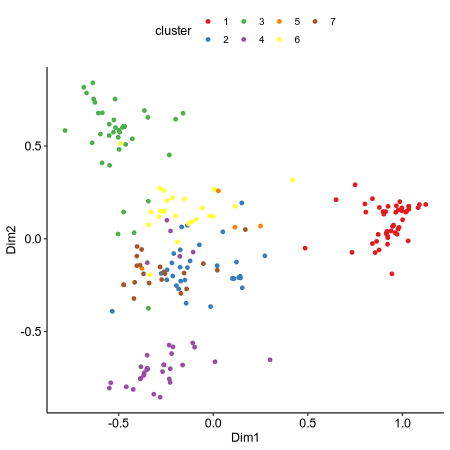

In [21]:
options(repr.plot.width=6, repr.plot.height=6,repr.plot.res=75)
ps[[1]]

# Read Mito redeem data

In [22]:
## Read Batch1 mito genotypes and depths
WD<-paste(Dir,"/data/CRISPR/batch1/",sep="")
MKP.depth<-readRDS(paste(WD,"/MKP_.depth",sep=""))
RawGenotype<-read.table(paste(WD,"RawGenotypes.Total.StrandBalance",sep=""))
RawGenotype<-RawGenotype %>% mutate(V2=gsub("_1","",Translate_simple_RNA2ATAC(V2)))
RawGenotype.list<-list()
for(i in 1:6){
    RawGenotype.sub<-subset(RawGenotype, V2 %in% CellNames[[i]])
    RawGenotype.list<-c(RawGenotype.list,list(RawGenotype.sub))
}
names(RawGenotype.list)<-Samples.batch1

#### Change MKP.depth name into ATAC names
MKP.depth<-lapply(MKP.depth,function(x){
    out<-x
    out[[2]]<-out[[2]] %>% mutate(V1=gsub("_1","",Translate_simple_RNA2ATAC(V1)))
    return(out)                        
})

The following `from` values were not present in `x`: 2, 3

The following `from` values were not present in `x`: 2, 3

The following `from` values were not present in `x`: 2, 3

The following `from` values were not present in `x`: 2, 3

The following `from` values were not present in `x`: 2, 3



In [23]:
## Read Batch2 mito genotypes and depths
WD<-paste(Dir,"/data/CRISPR/batch2/",sep="")
MKP.depth.batch2<-readRDS(paste(WD,"/MKP2.depth",sep=""))
RawGenotype.batch2<-read.table(paste(WD,"RawGenotypes.Total.StrandBalance",sep=""))
#RawGenotype.batch2<-RawGenotype.batch2 %>% mutate(V2=gsub("_1","",Translate_simple_RNA2ATAC(V2)))
RawGenotype.list.batch2<-list()
for(i in 1:6){
    RawGenotype.sub<-subset(RawGenotype.batch2, V2 %in% CellNames.batch2[[i]])
    RawGenotype.list.batch2<-c(RawGenotype.list.batch2,list(RawGenotype.sub))
}
names(RawGenotype.list.batch2)<-names(whm.list.batch2)

In [24]:
names(RawGenotype.list)
names(RawGenotype.list.batch2)

[1] "CD24_1" "CD47_1" "CD47_2" "Ctrl_1" "Ctrl_2" "DKO_1"

[1] "NT1"   "NT2"   "T24_1" "T24_2" "T24_3" "T47_1"

## Get mito_master.list

In [25]:
## get whitelist for batch1
MKP_mitoTracing.VerySensitive<-readRDS(paste(Dir,"/data/CRISPR/batch1/MKP_mitoTracing.VerySensitive",sep=""))
dim(MKP_mitoTracing.VerySensitive@Cts.Mtx.bi)
MKP_WhiteList<-colnames(MKP_mitoTracing.VerySensitive@Cts.Mtx.bi)

[1] 7258 2027

In [26]:
## get whitelist for batch2
MKP2_mitoTracing.VerySensitive<-readRDS(paste(Dir,"/data/CRISPR/batch2/MKP2_mitoTracing.VerySensitive",sep=""))
dim(MKP2_mitoTracing.VerySensitive@Cts.Mtx.bi)
MKP2_WhiteList<-colnames(MKP2_mitoTracing.VerySensitive@Cts.Mtx.bi)

[1] 7251 2684

In [52]:
mito_master.list<-list()
for(i in 1:6){
    mito_master<-Make_MitoTracing_VS(RawGenotype.list[[i]],depth =MKP.depth,Homo=c(),WhitelistV = MKP_WhiteList)
    mito_master.list<-c(mito_master.list,list(mito_master))
}
names(mito_master.list)<-Samples.batch1

[1] 2
[1] "Sensitive :\n 4675 variants to start"
[1] "4586 variants after remove low quality cells"
[1] 2
[1] "After filtering, 166 Variants left"
[1] "\n\n"


Create_mitoTracing has been deprecated, please use Create_redeemR



[1] 2
[1] "Sensitive :\n 3482 variants to start"
[1] "3402 variants after remove low quality cells"
[1] 2
[1] "After filtering, 87 Variants left"
[1] "\n\n"


Create_mitoTracing has been deprecated, please use Create_redeemR



[1] 2
[1] "Sensitive :\n 5108 variants to start"
[1] "5015 variants after remove low quality cells"
[1] 2
[1] "After filtering, 194 Variants left"
[1] "\n\n"


Create_mitoTracing has been deprecated, please use Create_redeemR



[1] 2
[1] "Sensitive :\n 5583 variants to start"
[1] "5490 variants after remove low quality cells"
[1] 2
[1] "After filtering, 229 Variants left"
[1] "\n\n"


Create_mitoTracing has been deprecated, please use Create_redeemR



[1] 2
[1] "Sensitive :\n 3167 variants to start"
[1] "3098 variants after remove low quality cells"
[1] 2
[1] "After filtering, 103 Variants left"
[1] "\n\n"


Create_mitoTracing has been deprecated, please use Create_redeemR



[1] 2
[1] "Sensitive :\n 4860 variants to start"
[1] "4744 variants after remove low quality cells"
[1] 2
[1] "After filtering, 187 Variants left"
[1] "\n\n"


Create_mitoTracing has been deprecated, please use Create_redeemR



In [53]:
mito_master.list.batch2<-list()
for(i in 1:6){
    mito_master.batch2<-Make_MitoTracing_VS(RawGenotype.list.batch2[[i]],depth =MKP.depth.batch2,Homo=c(),WhitelistV = MKP2_WhiteList)
    mito_master.list.batch2<-c(mito_master.list.batch2,list(mito_master.batch2))
}
names(mito_master.list.batch2)<-names(whm.list.batch2)

[1] 2
[1] "Sensitive :\n 32358 variants to start"
[1] "32290 variants after remove low quality cells"
[1] 2
[1] "After filtering, 2252 Variants left"
[1] "\n\n"


Create_mitoTracing has been deprecated, please use Create_redeemR



[1] 2
[1] "Sensitive :\n 17446 variants to start"
[1] "17365 variants after remove low quality cells"
[1] 2
[1] "After filtering, 1067 Variants left"
[1] "\n\n"


Create_mitoTracing has been deprecated, please use Create_redeemR



[1] 2
[1] "Sensitive :\n 26785 variants to start"
[1] "26729 variants after remove low quality cells"
[1] 2
[1] "After filtering, 1869 Variants left"
[1] "\n\n"


Create_mitoTracing has been deprecated, please use Create_redeemR



[1] 2
[1] "Sensitive :\n 30537 variants to start"
[1] "30493 variants after remove low quality cells"
[1] 2
[1] "After filtering, 2124 Variants left"
[1] "\n\n"


Create_mitoTracing has been deprecated, please use Create_redeemR



[1] 2
[1] "Sensitive :\n 19813 variants to start"
[1] "19772 variants after remove low quality cells"
[1] 2
[1] "After filtering, 1267 Variants left"
[1] "\n\n"


Create_mitoTracing has been deprecated, please use Create_redeemR



[1] 2
[1] "Sensitive :\n 15627 variants to start"
[1] "15478 variants after remove low quality cells"
[1] 2
[1] "After filtering, 921 Variants left"
[1] "\n\n"


Create_mitoTracing has been deprecated, please use Create_redeemR



In [54]:
mito_master.list<-c(mito_master.list,mito_master.list.batch2)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12


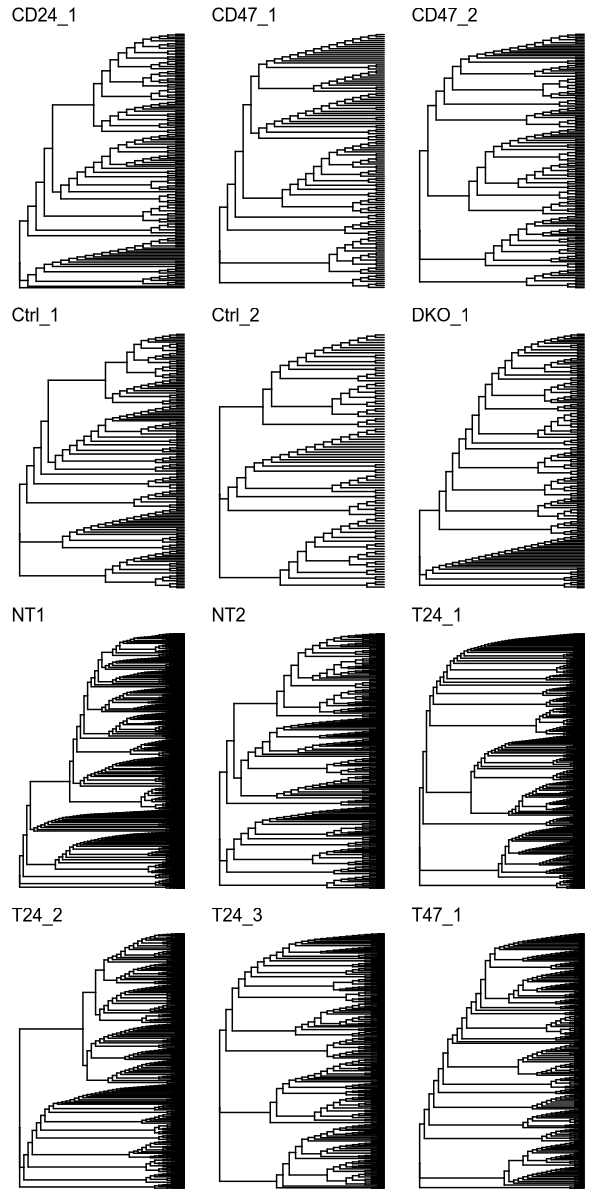

In [65]:
ps<-list()
phylo.list<-list()
for(i in 1:12){
print(i)
phylo.list<-c(phylo.list,list(mito_master.list[[i]]$phylo))
p<-ggtree(as.treedata(mito_master.list[[i]]$phylo),branch.length="none")+ggtitle(names(mito_master.list)[i])
ps<-c(ps,list(p))
}
# names(ps)<-Samples
options(repr.plot.width=6, repr.plot.height=12,repr.plot.res=100)
grid.arrange(grobs=ps)